# The Data
The first thing to do is to get the data. I've stored the data in a relational database for flexibility. 

## Get the Data
I have written a function that cleans, and fetches the data that is necessary for predicting votes. This is the vote_predict.fetch_data function. vote_predict is a module holding various helper functions for doing this analysis.

In [88]:
from scotus.db import DB
from scotus.settings import DEFAULT_DB
from scotus.learn import vote_predict

database = DB(DEFAULT_DB)
all_data = vote_predict.fetch_data(database)

## Organize
For this demo I am only going to focus on the votes of Justice Kennedy. So I will filter out the other data.  Additionally, I will save the case names, so I can use them for labelling later.

In [89]:
def justice_data(justice_id, data):
    '''split out the data for a single justice given the justice id'''
    d = data[data['justice_id']==justice_id]
    d = d[d['vote'] != 'none']
    return d

kennedy_data = justice_data(9, all_data)

case_names = kennedy_data['name']

# Make the Features
Because my fetch_data function returns a pandas dataframe, that contains statistics as well as document data my feature generation process is slightly complicated. 

## Docment Pipeline
My dataframe contains several columns that have documents in them. These need to be extracted processed into latant semantic space, before I can combine them with other features. I need to generate a mini-pipeline that will take each document column and generate latant semantic features for it. This is done with the function DocumentPipeline that will construct such a pipeline given the column name.

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

class DocumentList(BaseEstimator, TransformerMixin):
    def __init__(self, column_id=None):
        self.column_id = column_id
    
    def fit(self, X, y=None):
        return self
  
    def transform(self, X, y=None):
        return X[self.column_id].tolist()

def DocumentPipeline(column):
    return Pipeline([('extract', DocumentList(column_id=column)),
                     ('tfidf', TfidfVectorizer(min_df=2, max_df=.95, stop_words='english', sublinear_tf=True)),
                     ('lsa', TruncatedSVD(n_components=100))])

## Sklearn_pandas
The library sklearn_pandas allows me to map my numeric columns directly to a numpy array that I can put into my algorithm. Additionally I can pipe my categorical features through LabelEncoders directly so all my data is numeric and ready to go.

In [91]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder

statistics = DataFrameMapper([
                ('gender_petitioner', LabelEncoder()),
                ('gender_respondent', LabelEncoder()),
                ('interrupted_petitioner', None),
                ('interrupted_respondent', None),
                ('interrupting_petitioner', None),
                ('interrupting_respondent', None),
                ('number_turns_petitioner', None),
                ('number_turns_respondent', None),
                ('speaking_time_petitioner', None),
                ('speaking_time_respondent', None),
                ('turn_length_petitioner', None),
                ('turn_length_respondent', None),
                ('justice_interrupted_petitioner', None),
                ('justice_interrupted_respondent', None),
                ('justice_interrupting_petitioner', None),
                ('justice_interrupting_respondent', None),
                ('justice_number_turns_petitioner', None),
                ('justice_number_turns_respondent', None),
                ('justice_speaking_time_petitioner', None),
                ('justice_speaking_time_respondent', None),
                ('justice_turn_length_petitioner', None),
                ('justice_turn_length_respondent', None),
                ])

## Feature Union
Now I can combine my document extraction pipeline and my dataframe mapper using scikit-learn's FeatureUnion. The benefit of having everything in Pipelines and FeatureUnions is that I can use this to crossvalidate and gridsearch with the scikit-learn framework.

In [92]:
from sklearn.pipeline import FeatureUnion

features = FeatureUnion([
            ('facts', DocumentPipeline('facts')),
            ('document_petitioner', DocumentPipeline('document_petitioner')),
            ('document_respondent', DocumentPipeline('document_respondent')),
            ('justice_document_petitioner', DocumentPipeline('justice_document_petitioner')),
            ('justice_document_respondent', DocumentPipeline('justice_document_respondent')),
            ('statistics', statistics)])

## Output Processor
My output variable is stored as a string that labels which side the Justice voted on. I need to encode it, so I will use sklearn-pandas to make a mapper for that purpose.

In [93]:
y_mapper = DataFrameMapper([('vote', LabelEncoder())])

# Exploration
Now that I have my features all set up, I would like to take a look and see what's going on. To that end I will do PCA and plot the results to see what kind of separation my classes (petitioner and respondent) are getting from these features.


In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

class DocumentList(BaseEstimator, TransformerMixin):
    def __init__(self, column_id=None):
        self.column_id = column_id
    
    def fit(self, X, y=None):
        return self
  
    def transform(self, X, y=None):
        return X[self.column_id].tolist()

def DocumentPipeline(column):
    return Pipeline([('extract', DocumentList(column_id=column)),
                     ('tfidf', TfidfVectorizer(min_df=1, sublinear_tf=True)),
                     ('lsa', TruncatedSVD(n_components=100))])

features = FeatureUnion([
            ('facts', DocumentPipeline('facts')),
            ('document_petitioner', DocumentPipeline('document_petitioner')),
            ('document_respondent', DocumentPipeline('document_respondent')),
            ('justice_document_petitioner', DocumentPipeline('justice_document_petitioner')),
            ('justice_document_respondent', DocumentPipeline('justice_document_respondent')),
            ('statistics', statistics)])

explore = Pipeline([
              ('features', features),
              ('scale', StandardScaler())])

raw_data = explore.fit_transform(kennedy_data)
y = y_mapper.fit_transform(kennedy_data).flatten()


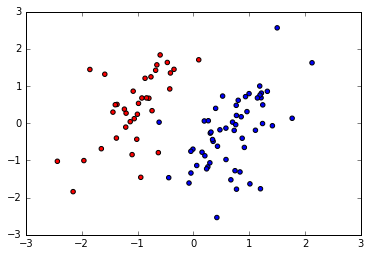

In [110]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import f_classif

select = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=100)
X = select.fit_transform(raw_data, y=y.flatten())

pca = PCA(whiten=True)
X = pca.fit_transform(X)
      
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='bwr')

In [114]:
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import KernelPCA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#numeric_data = features.fit_transform(kennedy_data)

from sklearn.pipeline import FeatureUnion


predict = Pipeline([
              ('features', features),
              ('scale', StandardScaler()),
              ('select', GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=100)),
              ('pca', PCA(whiten=True)),
              #('pca', KernelPCA(kernel='linear')),
              #('predict', SVC(probability=True, kernel='poly'))])
              ('predict', LinearDiscriminantAnalysis())])



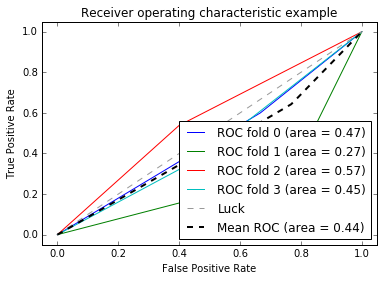

In [115]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
cv = KFold(len(y), n_folds=4, shuffle=True)
for i, (train, test) in enumerate(cv):
    probas_ = predict.fit(kennedy_data.iloc[train], y[train]).predict_proba(kennedy_data.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [98]:
len(kennedy_data)

92

In [99]:
np.sum(y)

36

In [23]:
with open('all_data.csv', 'wb') as f:
    n_data.to_csv(f, encoding='utf-8')